In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import random
import h3

In [4]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)
h3_l7_df

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

print(len(train_index))
print(len(test_index))

83
94


In [5]:
class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output

In [6]:
window_size = 1
seed = 123 #7890
torch.manual_seed(seed)
np.random.seed(seed)

def train_reg(spatial_data, 
              s_net,
              s_net_optim, 
              window_size, iter_num=5000):
    """
    訓練 s_net  網絡來預測 spatial_data 中的數據。
    
    參數:
    - spatial_data: numpy array，包含訓練數據
    - s_net: 神經網絡模型
    - s_net_optim: 優化器
    - window_size: 每次迭代的隨機取樣大小
    - iter_num: 訓練迭代次數
    
    返回:
    - loss_array: 每次迭代的損失值
    - t_fea_array, s_fea_array: 用於存儲特徵的暫時性陣列（目前未使用）
    """

    loss_array = []     # 儲存每次迭代的損失
    t_fea_array = []    # 預留用於儲存暫時性特徵的空列表
    s_fea_array = []    # 預留用於儲存暫時性特徵的空列表

    for _ in tqdm(range(iter_num)):
        
        # 隨機選擇一組數據索引
        h3_l7_id = np.random.choice(spatial_data.shape[0] - 1, window_size)


        # 提取目標變數（即輸入的最後一列數據）並轉為 Tensor
        ohca = spatial_data[h3_l7_id, -1].reshape(-1, 1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # p_pred 用於預測目標變數
        p_pred = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))).reshape(-1, 1)

        # 定義均方誤差損失
        mseloss = torch.nn.MSELoss(reduction='sum')
        loss = mseloss(p_pred, ohca)
        
        # 清空前一次計算的梯度
        s_net_optim.zero_grad()
        
        
        # 計算損失的梯度
        autograd.backward(loss)

        # 更新神經網絡參數
        s_net_optim.step()
        
        # 儲存損失值
        loss_array.append(loss.detach().cpu().numpy())

    return loss_array, t_fea_array, s_fea_array

# 初始化模型和優化器
s_net = Regressor(input_size=spatial_data.shape[1] - 1, hidden_size=spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr=1e-4, weight_decay=1e-5)

iter_num=5000
# 執行訓練過程
loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net,
                                                 s_net_optim,
                                                 window_size, iter_num)

100%|██████████| 5000/5000 [00:10<00:00, 482.51it/s]


In [7]:
y_head_train = s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_train = train_spatial_data[:, -1]*ohca_reguli_inverse
y_head_test = s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_test = test_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse



mae = np.abs(y_head_test-y_test)
ans_mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',ans_mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_head_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

n = mae.shape[0]          # Number of data points
p = train_spatial_data.shape[1]            # Number of predictors

# Adjusted R-squared calculation
r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R² of test set= ", r_squared)
print("ADJ R² of test set= ", r_squared_adj)

MAE of test set=  5.583852468018836
R² of test set=  0.7586561695152917
ADJ R² of test set=  2.0202261925035394


# LIME

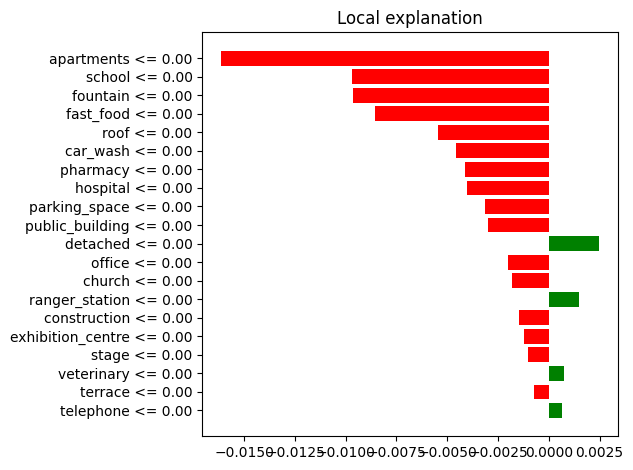

In [10]:
from lime import lime_tabular
import matplotlib.pyplot as plt
import numpy as np

test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns
# 假設 `spatial_data` 包含背景數據，用於 SHAP 的解釋
background_data = torch.FloatTensor(train_spatial_data[:, :-1])  
test_data = torch.FloatTensor(test_spatial_data[:, :-1])     


# Step 1: 建立 PyTorch 模型的預測函數（符合 LIME 格式）
def s_net_predict_fn(x):
    x_tensor = torch.FloatTensor(x)
    with torch.no_grad():
        preds = s_net(x_tensor).cpu().numpy().flatten()
    return preds

# Step 2: 準備訓練資料給 LIME（X_train_reguli 需已標準化過）
explainer = lime_tabular.LimeTabularExplainer(
    training_data=background_data.numpy(),   # 確保是 NumPy 格式
    feature_names=feature_names,
    mode='regression',
    kernel_width=0.75,
    discretize_continuous=True,
    discretizer='decile',
    random_state=42
)

# Step 3: 選擇一筆測試資料進行解釋
idx = 36
exp = explainer.explain_instance(
    test_data[idx].numpy(),   # Tensor -> NumPy
    s_net_predict_fn,
    num_features=20
)

# Step 4: 顯示解釋結果（在 notebook 內顯示表格 & 繪圖）
exp.show_in_notebook(show_table=True, show_all=True)
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


In [14]:
# 提取貢獻值
exp = explainer.explain_instance(
    test_data[idx].numpy(),   # Tensor -> NumPy
    s_net_predict_fn,
    num_features=20
)
contributions = exp.as_list()
contributions_set = (contributions,0)
def convert_to_dic(contributions_set):
    contribution_dict = {}
    contribution = contributions_set[0]
    Index = contributions_set[-1]
    print(Index)
    for i in range(0, len(contribution)-1):
        raw_feature = contribution[i][0]
        feature_name = re.sub(r'[^a-zA-Z_;]', '', raw_feature)
        if feature_name in feature_names:
            feature_val = test_h3_l7_df[feature_name].iloc[Index]
        else:
            feature_val = "?"
        feature_name = feature_name + ' = ' + str(feature_val)
        contribution_dict[feature_name] = contribution[i][1]

    return contribution_dict


contribution_dict = convert_to_dic(contributions_set)
contribution_dict

0


{'apartments = 0': -0.018717939081034415,
 'school = 0': -0.009776874174551864,
 'fast_food = 0': -0.007675686798937986,
 'fountain = 0': -0.007078659515070852,
 'car_wash = 0': -0.0062437827228928,
 'roof = 0': -0.005856023879440427,
 'parking_space = 0': -0.005650895286917013,
 'pharmacy = 0': -0.004187699657150443,
 'hospital = 0': -0.0038991998744832114,
 'church = 0': -0.003588270231534673,
 'veterinary = 0': 0.0022719566727838567,
 'ranger_station = 0': 0.0018720232664185762,
 'exhibition_centre = 0': -0.0018659770242983951,
 'parking_entrance = 0': -0.001804972372754645,
 'public_building = 0': -0.0016402980710501656,
 'post_office = 0': 0.0014984374482296717,
 'hotel = 0': -0.0012210009273983882,
 'detached = 0': 0.0009759717389538536,
 'telephone = 0': 0.0006837978132809279}

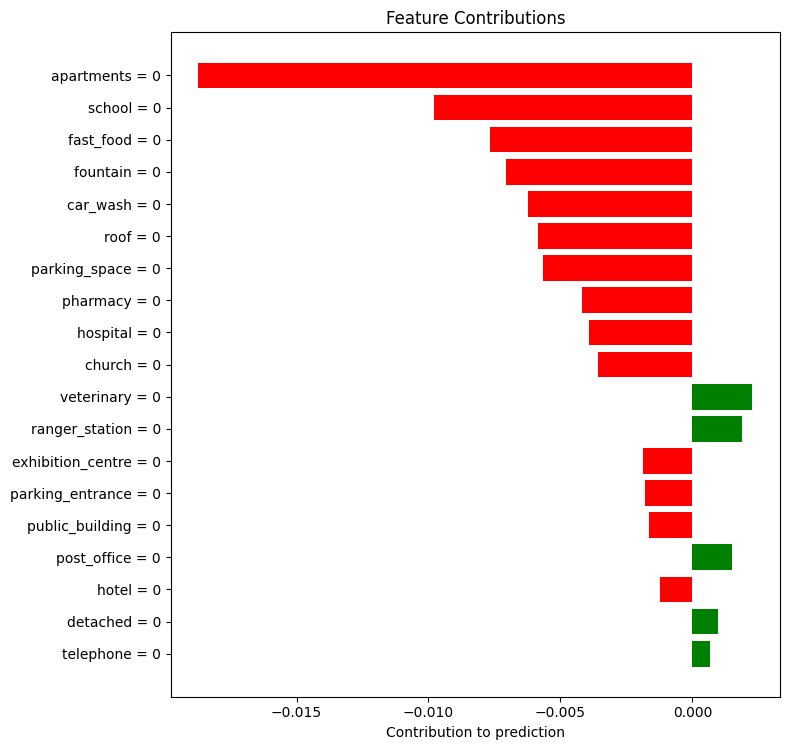

In [15]:
def Lime_chart(contribution_dict):
    # 將貢獻字典按值排序（從大到小）
    sorted_contrib = sorted(contribution_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    # 拆分成兩個 list
    features = [item[0] for item in sorted_contrib]
    contributions = [item[1] for item in sorted_contrib]

    # 畫圖
    plt.figure(figsize=(8, len(features) * 0.4))  # 高度依特徵數自動調整
    plt.barh(features, contributions, color=['green' if c >= 0 else 'red' for c in contributions])

    plt.xlabel("Contribution to prediction")
    plt.title("Feature Contributions")
    plt.gca().invert_yaxis()  # 讓最大貢獻的在上方
    plt.tight_layout()
    plt.show()

Lime_chart(contribution_dict)

# 實現 SP-LIME 的子模塊優化

In [18]:
from tqdm import tqdm  # 用於顯示進度條
# 為每個測試樣本生成解釋
explanations = []
for i in tqdm(range(len(background_data))):
    exp = explainer.explain_instance(
    test_data[i].numpy(),   # Tensor -> NumPy
    s_net_predict_fn,
    num_features=20
)
    explanations.append((exp,i))

100%|██████████| 83/83 [00:10<00:00,  7.87it/s]


In [19]:
def submodular_pick(explanations, num_explanations):
    """
    使用貪婪算法進行子模塊優化，選擇代表性的解釋。
    
    :param explanations: 所有生成的解釋
    :param num_explanations: 要選擇的解釋數量
    :return: 選擇的代表性解釋
    """
    selected_explanations = []
    remaining_explanations = explanations.copy()
    
    # 計算每個解釋的特徵覆蓋範圍
    def coverage(exp):
        return set([f[0] for f in exp.as_list()])
    
    # 貪婪選擇
    for _ in range(num_explanations):
        best_exp = None
        best_gain = -1
        
        for exp in remaining_explanations:
            current_coverage = set()
            for selected_exp in selected_explanations:
                current_coverage.update(coverage(selected_exp[0]))
            
            new_coverage = current_coverage.union(coverage(exp[0]))
            gain = len(new_coverage) - len(current_coverage)
            
            if gain > best_gain:
                best_gain = gain
                best_exp = exp
        
        if best_exp is not None:
            selected_explanations.append((best_exp))
            remaining_explanations.remove((best_exp))
    
    return selected_explanations

Explanation 1:
0


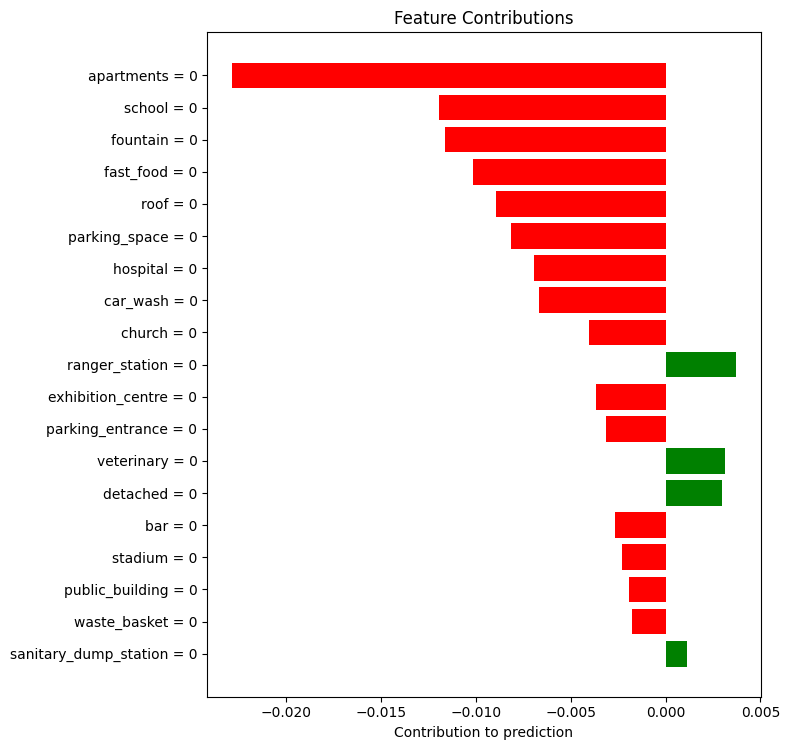

Explanation 2:
23


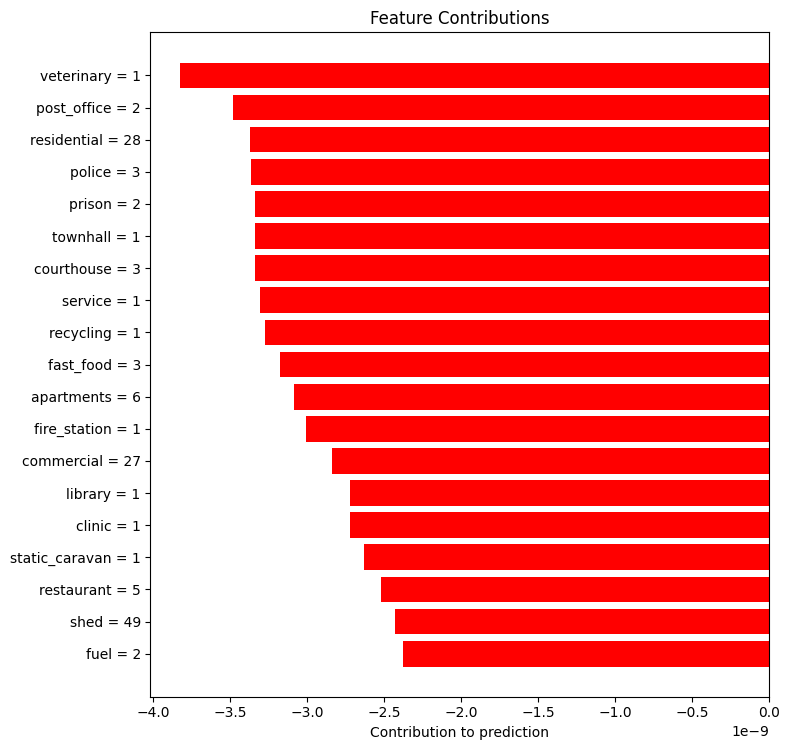

Explanation 3:
74


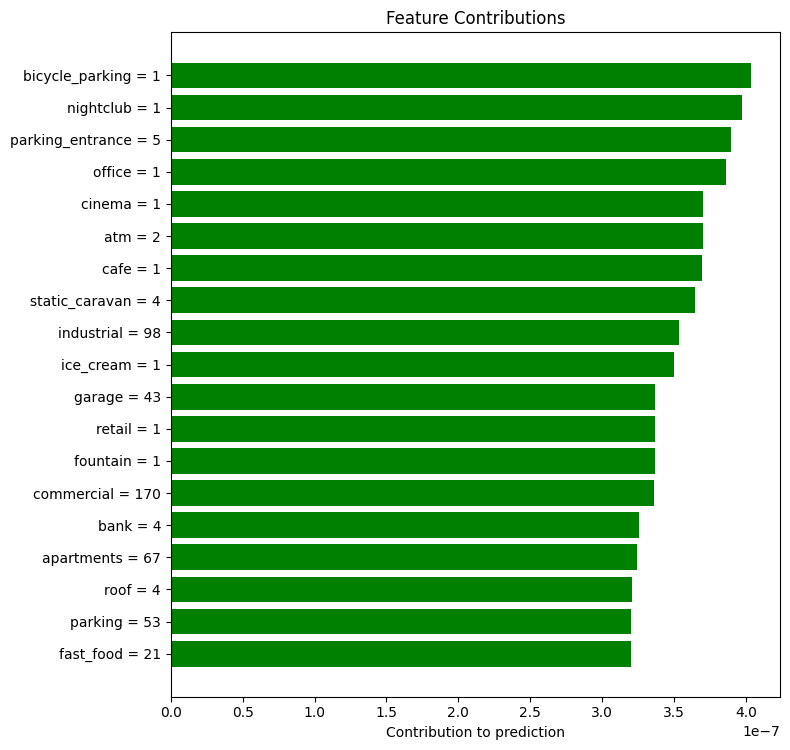

Explanation 4:
33


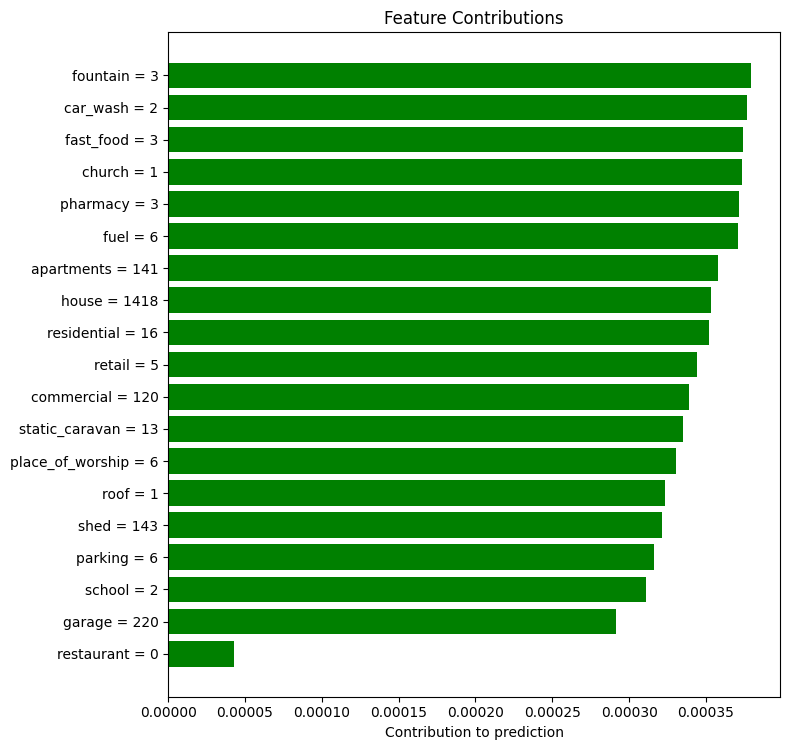

Explanation 5:
27


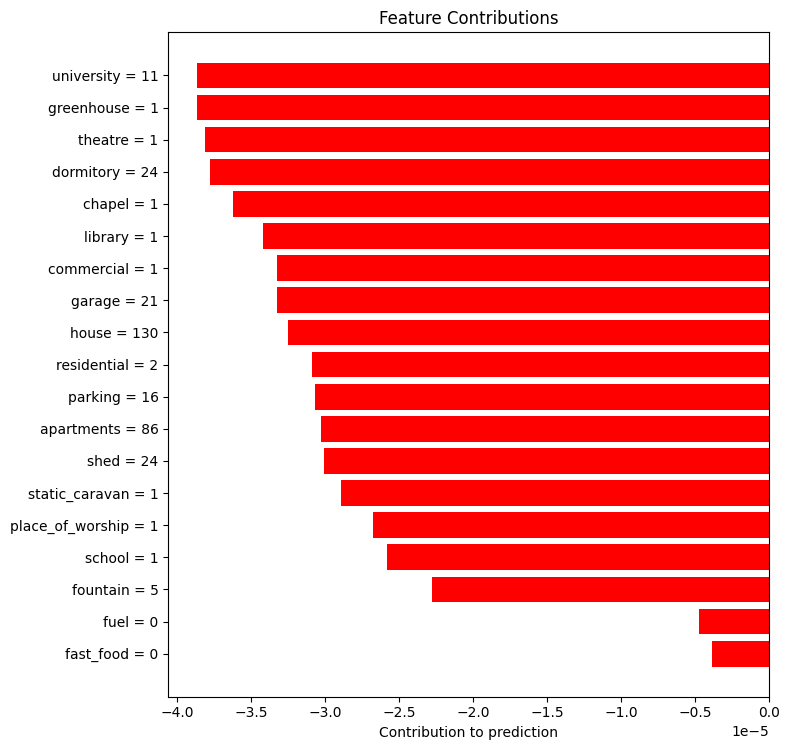

In [20]:
# 選擇 5 個代表性的解釋
num_explanations = 5
selected_explanations = submodular_pick(explanations, num_explanations)

# 打印選擇的解釋
for i, exp in enumerate(selected_explanations):
    print(f"Explanation {i+1}:")
    contribution = exp[0].as_list()
    contribution_set = (contribution,exp[1])
    contribution_dic = convert_to_dic(contribution_set)
    Lime_chart(contribution_dic)